<div style='font-size:200%;'>
    <a></a>
    <h1 style='color: green; font-weight: bold; font-family: Cascadia code;'>
        <center>MALIGNANCY DETECTION IN LUNG NODULES USING CNN</center>
    </h1>
</div>

- - -

- - -


Lung cancer, a leading cause of cancer deaths, requires early detection for successful treatment. We propose an automated system using machine learning on CT scans to aid radiologists in identifying suspicious lung nodules accurately. Methodology includes CT image preprocessing to enhance nodule features. Machine learning models like CNNs are trained on annotated CT scans to learn patterns of malignant and benign nodules. Various CNN architectures, including ResNet, DenseNet, and EfficientNet, are assessed to find the most effective model for detection.

- - -

<h1 ><a id='contents'><b>Contents<b></a></h1>

- Importing necessary libraries
- Proposed methodology
- Dataset Unzipping
- Augmentation
- Data Pre-processing
- Splitting the processed images
- Model Building
    - VGG16
- Training
- Accuracy
- References



- - -

<div style='font-size:100%;'>
    <a id='import'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Importing the necessary libraries</center>
    </h1>
</div>

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from IPython.display import Image
%matplotlib inline
plt.style.use('ggplot')

<div style='font-size:100%;'>
    <a id='method'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Proposed Methodology</center>
    </h1>
</div>

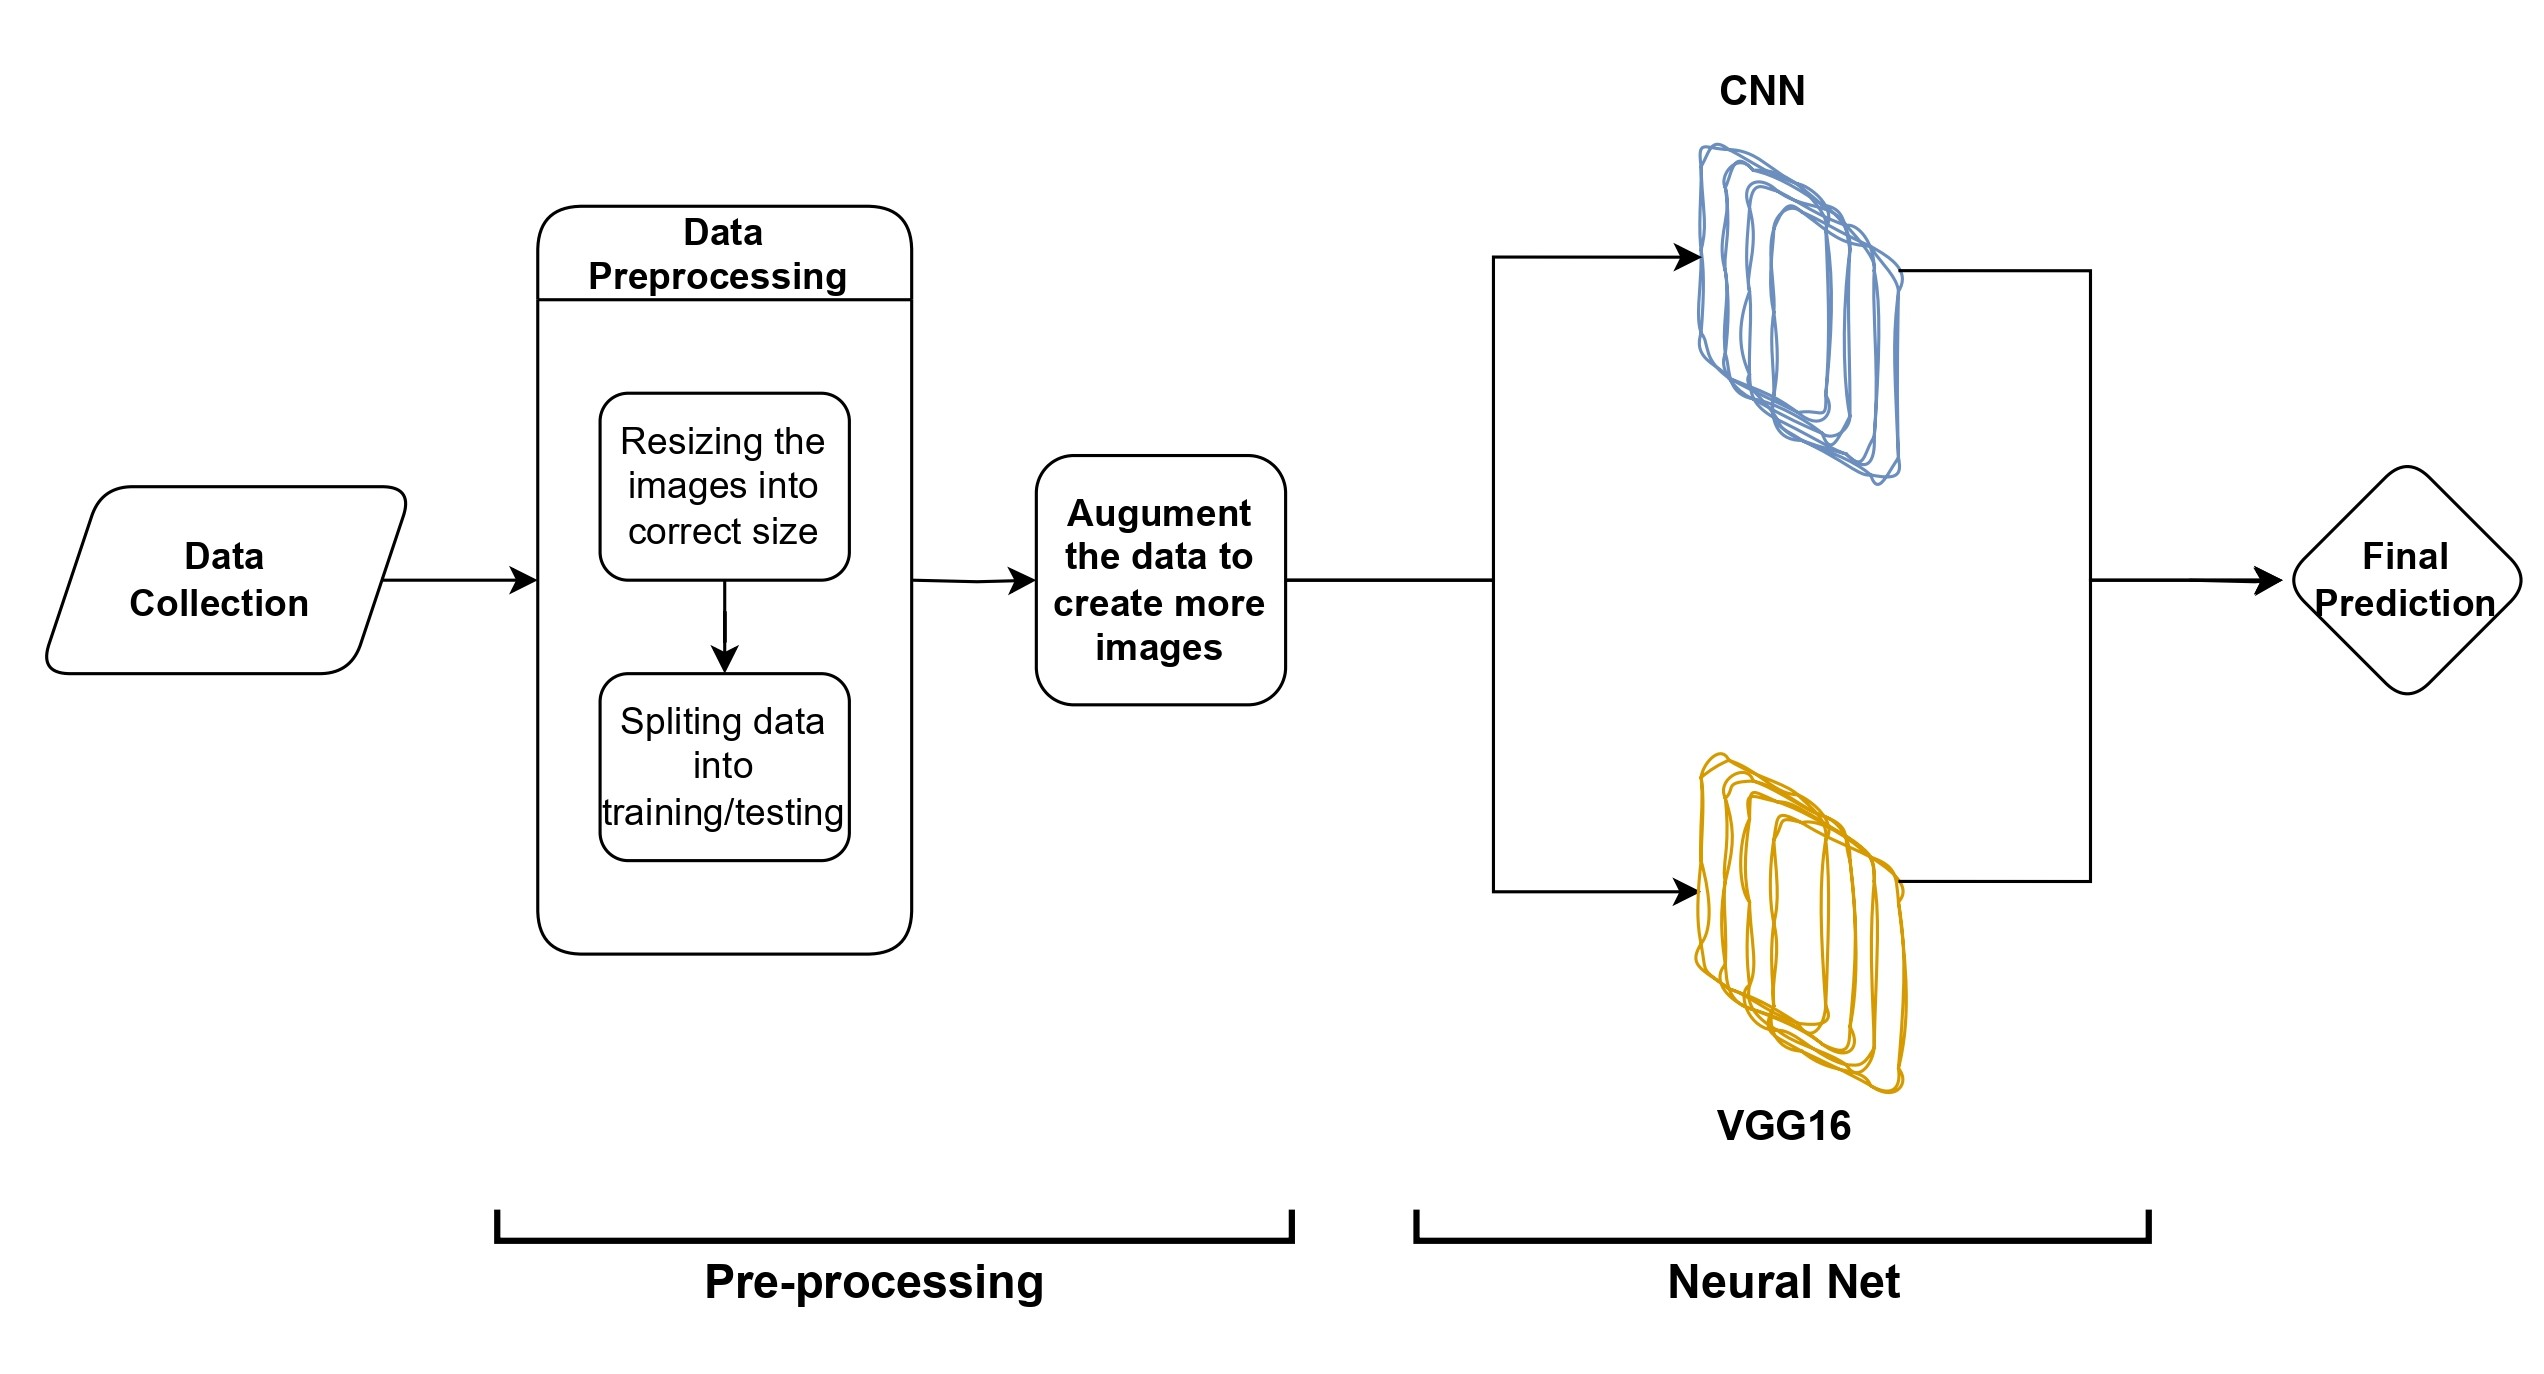

In [6]:
Image('./method.jpg')

<div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Dataset Unzipping</center>
    </h1>
</div>

In [2]:
# # Dataset
import zipfile

z = zipfile.ZipFile('archive.zip')

z.extractall()

In [3]:
folder = 'lung_cancer_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [4]:
folder = 'lung_cancer_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [6]:
listyes = os.listdir("lung_cancer_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("lung_cancer_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

300
215


  <div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Graph Plot Before <b>Augmentation</b></center>
    </h1>
</div>


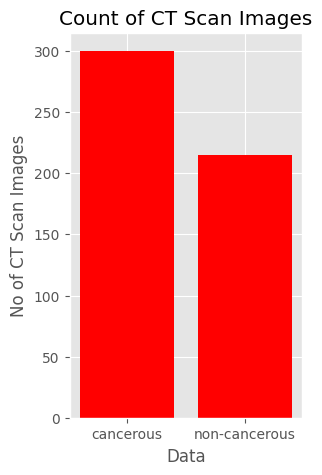

In [8]:
data = {'cancerous': number_files_yes, 'non-cancerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(3,5))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of CT Scan Images")
plt.title("Count of CT Scan Images")
plt.show()

  <div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Augmentation</center>
    </h1>
</div>


- Data Augmentation
   - 315(61%), 200(39%)
   - imbalance

In [11]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [12]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [14]:
import time
start_time = time.time()

yes_path = 'Lung_cancer_dataset/yes' 
no_path = 'Lung_cancer_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:2:19.462085247039795


In [15]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [16]:
data_summary(augmented_data_path)

Number of sample: 4250
2100 Number of positive sample in percentage: 49.411764705882355%
2150 Number of negative sample in percentage: 50.588235294117645%


  <div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Graph Plot After Augmentation</center>
    </h1>
</div>


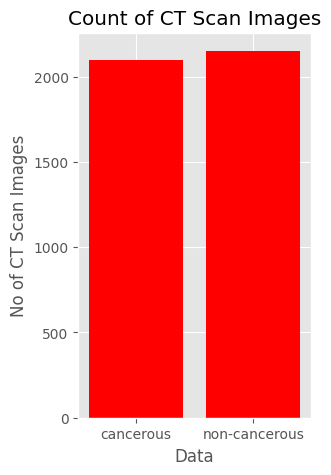

In [18]:
data = {'cancerous': number_files_yes, 'non-cancerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(3,5))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of CT Scan Images")
plt.title("Count of CT Scan Images")
plt.show()

  <div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Data Pre-processing</b></center>
    </h1>
</div>


- Convert BGR TO GRAY
- GaussianBlur
- Threshold
- Erode
- Dilate
- Find Contours

In [22]:
import imutils
def crop_ct_scan(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image
    

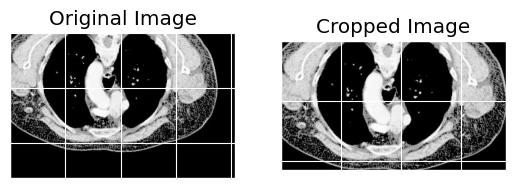

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_479.jpg')
crop_ct_scan(img, True)

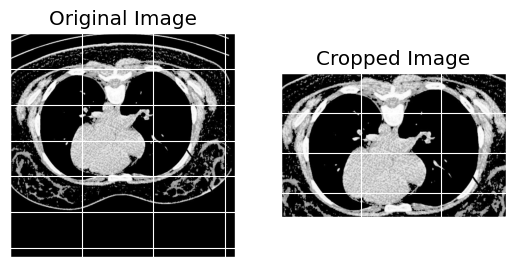

array([[[107, 107, 107],
        [ 11,  11,  11],
        [  6,   6,   6],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 17,  17,  17],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  3,   3,   3],
        ...,
        [ 72,  72,  72],
        [121, 121, 121],
        [146, 146, 146]],

       [[  2,   2,   2],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [151, 151, 151],
        [181, 181, 181],
        [192, 192, 192]],

       [[  2,   2,   2],
        [  3,   3,   3],
        [  0,   0,   0],
        ...,
        [181, 181, 181],
        [201, 201, 201],
        [209, 209, 209]]

In [28]:
img = cv2.imread('augmented_data/no/aug_N_1_0_3269.jpg')
crop_ct_scan(img, True)

In [29]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_ct_scan(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_ct_scan(img, False)
    cv2.imwrite(folder2 + filename, img)

# IMAGE LOADING

In [31]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_ct_scan(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y
            

In [32]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (224,224)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 4250
X SHAPE is : (4250, 224, 224, 3)
y SHAPE is : (4250,)


In [35]:
def plot_sample_images(X, y, n=25):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Lung Cancer: {label_to_str(label)}")
        plt.show()

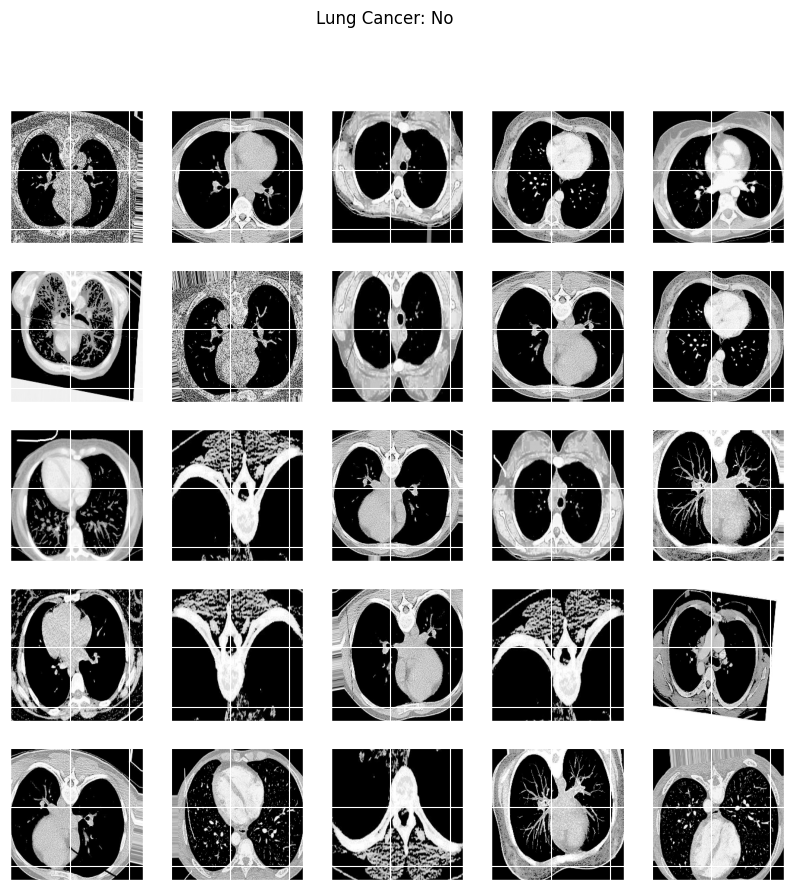

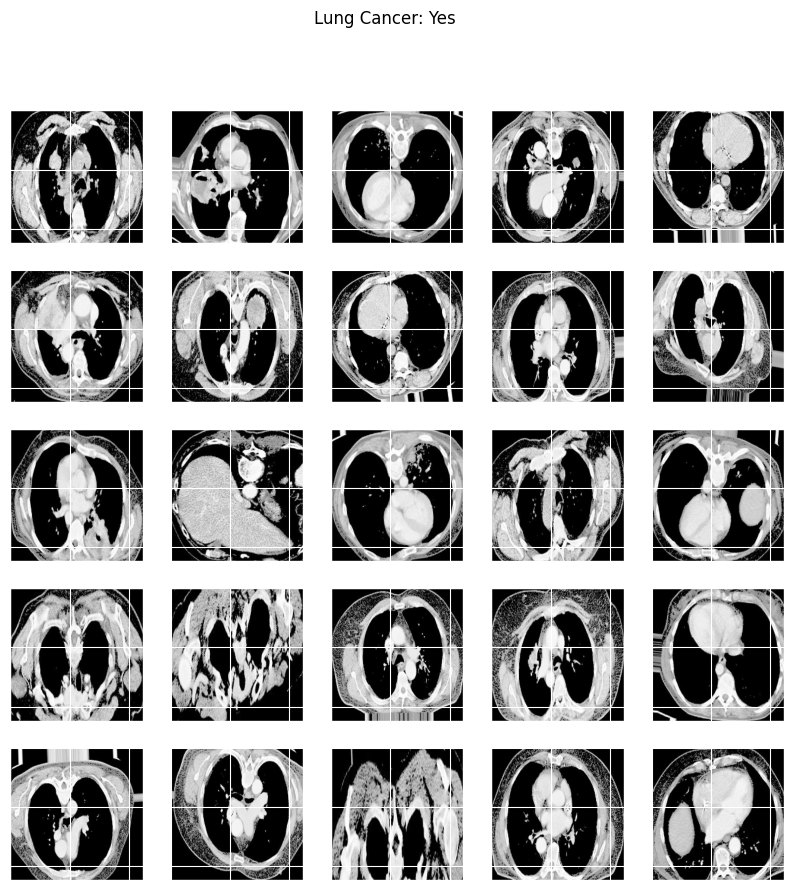

In [36]:
plot_sample_images(X,y)

- Data Spliting
  - Train
  - Test
  - Validation

In [38]:
if not os.path.isdir('cancerous_and_non-cancerous'):
    base_dir = 'cancerous_and_non-cancerous'
    os.mkdir(base_dir)

In [39]:
if not os.path.isdir('cancerous_and_non-cancerous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('cancerous_and_non-cancerous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('cancerous_and_non-cancerous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [41]:
if not os.path.isdir('cancerous_and_non-cancerous/train/cancerous'):
    infected_train_dir = os.path.join(train_dir, 'cancerous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('cancerous_and_non-cancerous/test/cancerous'):
    infected_test_dir = os.path.join(test_dir, 'cancerous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('cancerous_and_non-cancerous/valid/cancerous'):
    infected_valid_dir = os.path.join(valid_dir, 'cancerous')
    os.mkdir(infected_valid_dir)

In [42]:
if not os.path.isdir('cancerous_and_non-cancerous/train/non-cancerous'):
    healthy_train_dir = os.path.join(train_dir, 'non-cancerous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('cancerous_and_non-cancerous/test/non-cancerous'):
    healthy_test_dir = os.path.join(test_dir, 'non-cancerous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('cancerous_and_non-cancerous/valid/non-cancerous'):
    healthy_valid_dir = os.path.join(valid_dir, 'non-cancerous')
    os.mkdir(healthy_valid_dir)

In [43]:
original_dataset_cancerous = os.path.join('augmented_data','yes/')
original_dataset_noncancerous = os.path.join('augmented_data','no/')

In [53]:
print('Total data')
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print('Cancerous :',number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print('Non Cancerous :',number_files_no)

Total data
Cancerous : 2100
Non Cancerous : 2150


<h3>
70% For Training , 15% for Testing ,  15% for Validation
</h3>

In [54]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,1505):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_cancerous, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [55]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(1505,1820):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_cancerous, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [56]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(1820,2100):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_cancerous, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [57]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,1505):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_noncancerous, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [58]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(1505,1827):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_noncancerous, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [59]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(1827,2150):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_noncancerous, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

<div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [60]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [61]:
train_generator = train_datagen.flow_from_directory('cancerous_and_non-cancerous/train/', batch_size=32, target_size=(224,224), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 3010 images belonging to 2 classes.


In [62]:
test_generator = train_datagen.flow_from_directory('cancerous_and_non-cancerous/test/', batch_size=32, target_size=(224,224), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 637 images belonging to 2 classes.


In [63]:
valid_generator = train_datagen.flow_from_directory('cancerous_and_non-cancerous/valid/', batch_size=32, target_size=(224,224), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 603 images belonging to 2 classes.


In [64]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [65]:
class_name

{0: 'cancerous', 1: 'non-cancerous'}

<div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Model Building</center>
    </h1>
</div>

In [94]:
base_model = VGG19(input_shape = (224,224,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [95]:
# callback
filepath = 'model_01.weights.h5'

es = EarlyStopping(monitor='val_loss',
                   verbose = 1,
                   mode='auto',
                   patience=4
                )

cp = ModelCheckpoint(filepath,
                    monitor='val_loss',
                    verbose = 1,
                    save_best_only=True,
                    save_weights_only=False,
                    mode='auto'
                   )

lrr = ReduceLROnPlateau(monitor='val_accuarcy',
                        patience=3,
                        verbose = 1,
                        factor = 0.5,
                        min_lr = 1e-7
                        )

In [96]:

model_01.compile(loss='categorical_crossentropy', optimizer = Adam , metrics=['accuracy'])

<div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Training</center>
    </h1>
</div>

In [97]:
history_01 = model_01.fit(train_generator, steps_per_epoch =8, epochs = 36, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5384 - loss: 24.4296
Epoch 1: val_loss improved from inf to 2.06512, saving model to model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 132s 17s/step - accuracy: 0.5358 - loss: 24.3589 - val_accuracy: 0.5357 - val_loss: 2.0651 - learning_rate: 0.0010
Epoch 2/36


h:\Major_Project_Code\Env\lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5154 - loss: 2.1840
Epoch 2: val_loss improved from 2.06512 to 0.91572, saving model to model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 16s/step - accuracy: 0.5152 - loss: 2.1562 - val_accuracy: 0.4776 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 3/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6010 - loss: 0.8089
Epoch 3: val_loss did not improve from 0.91572
8/8 ━━━━━━━━━━━━━━━━━━━━ 120s 17s/step - accuracy: 0.5984 - loss: 0.8066 - val_accuracy: 0.5357 - val_loss: 1.2145 - learning_rate: 0.0010
Epoch 4/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6087 - loss: 0.9055
Epoch 4: val_loss improved from 0.91572 to 0.55421, saving model to model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 125s 17s/step - accuracy: 0.6123 - loss: 0.8871 - val_accuracy: 0.6584 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 5/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6376 - loss: 0.6946
Epoch 5: val_loss did not improve from 0.55421
8/8 ━━━━━━━━━━━━

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 12: val_loss did not improve from 0.17566
8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 15s/step - accuracy: 0.9209 - loss: 0.2148 - val_accuracy: 0.9071 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 13/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 15s/step - accuracy: 0.9209 - loss: 0.2148 - val_accuracy: 0.9071 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 13/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9085 - loss: 0.2198
Epoch 13: val_loss improved from 0.17566 to 0.17330, saving model to model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 125s 17s/step - accuracy: 0.9091 - loss: 0.2211 - val_accuracy: 0.9403 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 14/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8918 - loss: 0.2285
Epoch 14: val_loss did not improve from 0.17330
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 16s/step - accuracy: 0.8945 - loss: 0.2239 - val_accuracy: 0.9237 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 15/36
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9214 - loss: 0.1885
Epoch 15

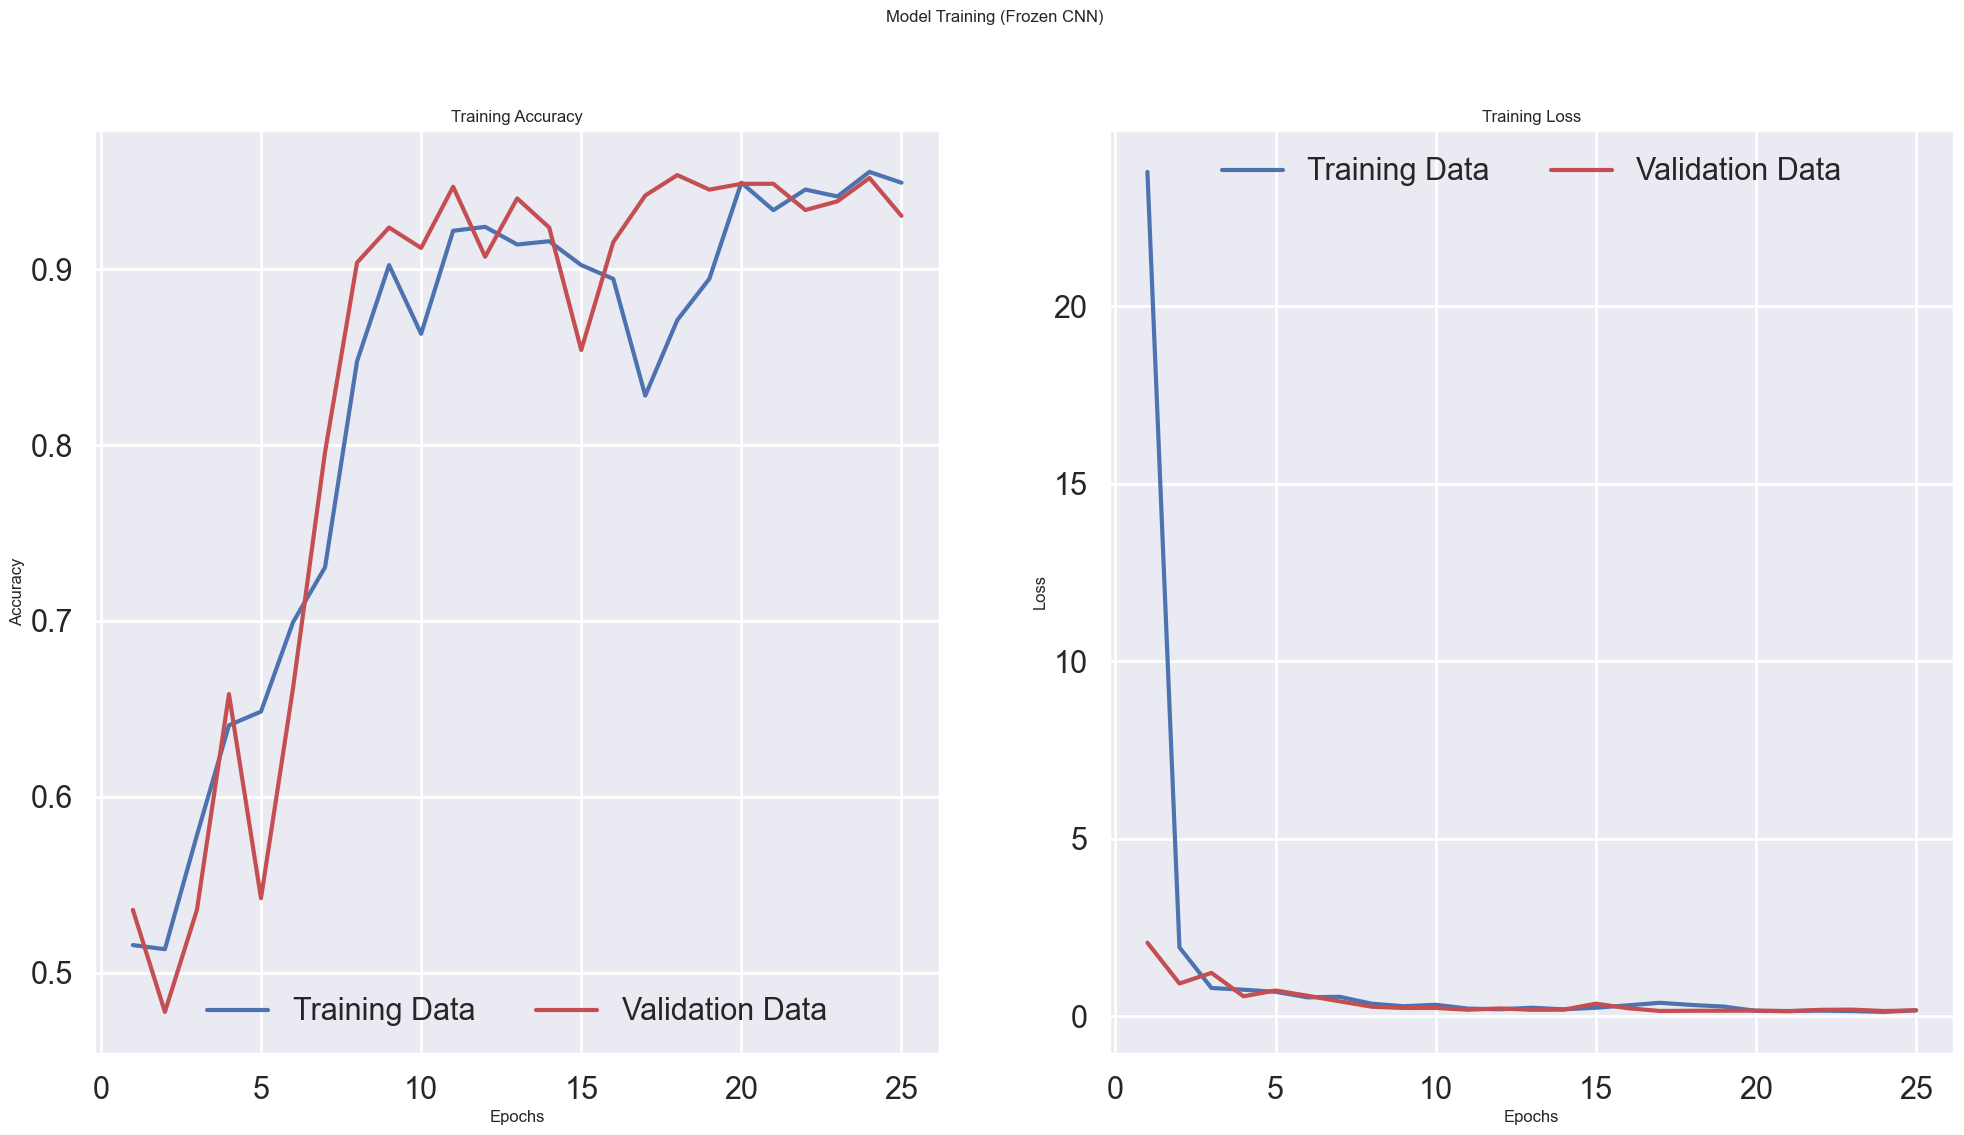

In [98]:
# # Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,12))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [99]:

model_01.save_weights(filepath="model_01.weights.h5", overwrite=True)

In [141]:
model_01.load_weights("model_01.weights.h5")

<div style='font-size:100%;'>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Accuracy</center>
    </h1>
</div>

In [142]:
from simple_colors import *
Accu = model_01.evaluate(test_generator, verbose=1)
print('Accuracy:', green( 100*Accu[1], 'bold'))

20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8854 - loss: 0.2903
Accuracy: 90.58084487915039
